In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
import shutil
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/dataset/corn_data'
train_dir = '/content/drive/MyDrive/corn/train'  # Update this path
validation_dir = '/content/drive/MyDrive/corn/valid'
test_dir = '/content/drive/MyDrive/corn/test'  # Update this path

In [ ]:
def clean_data(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify the image
                except (IOError, SyntaxError) as e:
                    print(f'Removing corrupted file: {file_path}')
                    os.remove(file_path)

# Clean the data
clean_data(dataset_path)

In [4]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [5]:
df = loading_the_data(dataset_path)
df

,filepaths,labels
0,/content/drive/MyDrive/dataset/corn_data/Gray_...,Gray_Leaf_Spot
1,/content/drive/MyDrive/dataset/corn_data/Gray_...,Gray_Leaf_Spot
2,/content/drive/MyDrive/dataset/corn_data/Gray_...,Gray_Leaf_Spot
3,/content/drive/MyDrive/dataset/corn_data/Gray_...,Gray_Leaf_Spot
4,/content/drive/MyDrive/dataset/corn_data/Gray_...,Gray_Leaf_Spot
...,...,...
1995,/content/drive/MyDrive/dataset/corn_data/Bligh...,Blight
1996,/content/drive/MyDrive/dataset/corn_data/Bligh...,Blight
1997,/content/drive/MyDrive/dataset/corn_data/Bligh...,Blight
1998,/content/drive/MyDrive/dataset/corn_data/Bligh...,Blight


In [6]:
data_balance = df.labels.value_counts()
data_balance

labels
Gray_Leaf_Spot    500
Common_Rust       500
Healthy           500
Blight            500
Name: count, dtype: int64

In [ ]:
def split_dataset(class_dir, split_ratio):
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    random.shuffle(images)
    total_images = len(images)

    train_end = int(total_images * split_ratio[0])
    val_end = train_end + int(total_images * split_ratio[1])

    train_images = images[:train_end]
    validation_images = images[train_end:val_end]
    test_images = images[val_end:]

    return train_images, validation_images, test_images

In [ ]:
# Function to copy files
def copy_files(image_list, destination_dir):
    for image in image_list:
        class_name = os.path.basename(os.path.dirname(image))
        dest_class_dir = os.path.join(destination_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        shutil.copy(image, dest_class_dir)

In [ ]:
split_ratio = [0.8, 0.1, 0.1]
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        train_images, validation_images, test_images = split_dataset(class_dir, split_ratio)

        copy_files(train_images, train_dir)
        copy_files(validation_images, validation_dir)
        copy_files(test_images, test_dir)

In [7]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode='categorical',
)

Found 1600 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [8]:
# Count the number of images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

# Count images in training, validation, and testing sets
train_class_counts = count_images(train_dir)
validation_class_counts = count_images(validation_dir)
test_class_counts = count_images(test_dir)

# Print the counts
print("Training Class Counts:", train_class_counts)
print("Validation Class Counts:", validation_class_counts)
print("Testing Class Counts:", test_class_counts)

Training Class Counts: {'Gray_Leaf_Spot': 400, 'Common_Rust': 400, 'Healthy': 400, 'Blight': 400}
Validation Class Counts: {'Gray_Leaf_Spot': 50, 'Common_Rust': 50, 'Healthy': 50, 'Blight': 50}
Testing Class Counts: {'Gray_Leaf_Spot': 50, 'Common_Rust': 50, 'Healthy': 50, 'Blight': 50}


In [9]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [10]:
# Load MobileNet model with pretrained weights
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

17225924/17225924 [==============================] - 0s 0us/step


In [16]:
# Add custom layers on top of MobileNet
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=l2(0.01))
])

# Compile the model with a modified learning rate
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
class LossThresholdCallback(Callback):
    def __init__(self, threshold=0.1):
        super(LossThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') < self.threshold and logs.get('val_loss') < self.threshold:
            print(f"\nEpoch {epoch + 1}: loss {logs.get('loss'):.4f} and val_loss {logs.get('val_loss'):.4f} are below {self.threshold}. Stopping training.")
            self.model.stop_training = True

In [13]:
loss_threshold = LossThresholdCallback(threshold=0.1)

In [17]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=validation_generator,
    callbacks=[loss_threshold]
)

Epoch 1/300
160/160 [==============================] - 405s 2s/step - loss: 7.8577 - accuracy: 0.6137 - val_loss: 7.4263 - val_accuracy: 0.7600
Epoch 2/300
160/160 [==============================] - 128s 802ms/step - loss: 7.3231 - accuracy: 0.7694 - val_loss: 7.0383 - val_accuracy: 0.8200
Epoch 3/300
160/160 [==============================] - 124s 773ms/step - loss: 7.0905 - accuracy: 0.7763 - val_loss: 6.8145 - val_accuracy: 0.8550
Epoch 4/300
160/160 [==============================] - 126s 785ms/step - loss: 6.8709 - accuracy: 0.8138 - val_loss: 6.5863 - val_accuracy: 0.8700
Epoch 5/300
160/160 [==============================] - 123s 764ms/step - loss: 6.6099 - accuracy: 0.8381 - val_loss: 6.4096 - val_accuracy: 0.9000
Epoch 6/300
160/160 [==============================] - 127s 791ms/step - loss: 6.4057 - accuracy: 0.8475 - val_loss: 6.2238 - val_accuracy: 0.9000
Epoch 7/300
160/160 [==============================] - 124s 777ms/step - loss: 6.2336 - accuracy: 0.8500 - val_loss: 6.02

In [18]:
# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')
print(f'Validation Loss: {val_loss:.2f}')

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Loss: {test_loss:.2f}')

20/20 [==============================] - 6s 281ms/step - loss: 0.4080 - accuracy: 0.9450
Validation Accuracy: 94.50%
Validation Loss: 0.41
20/20 [==============================] - 48s 3s/step - loss: 0.4784 - accuracy: 0.9300
Test Accuracy: 93.00%
Test Loss: 0.48


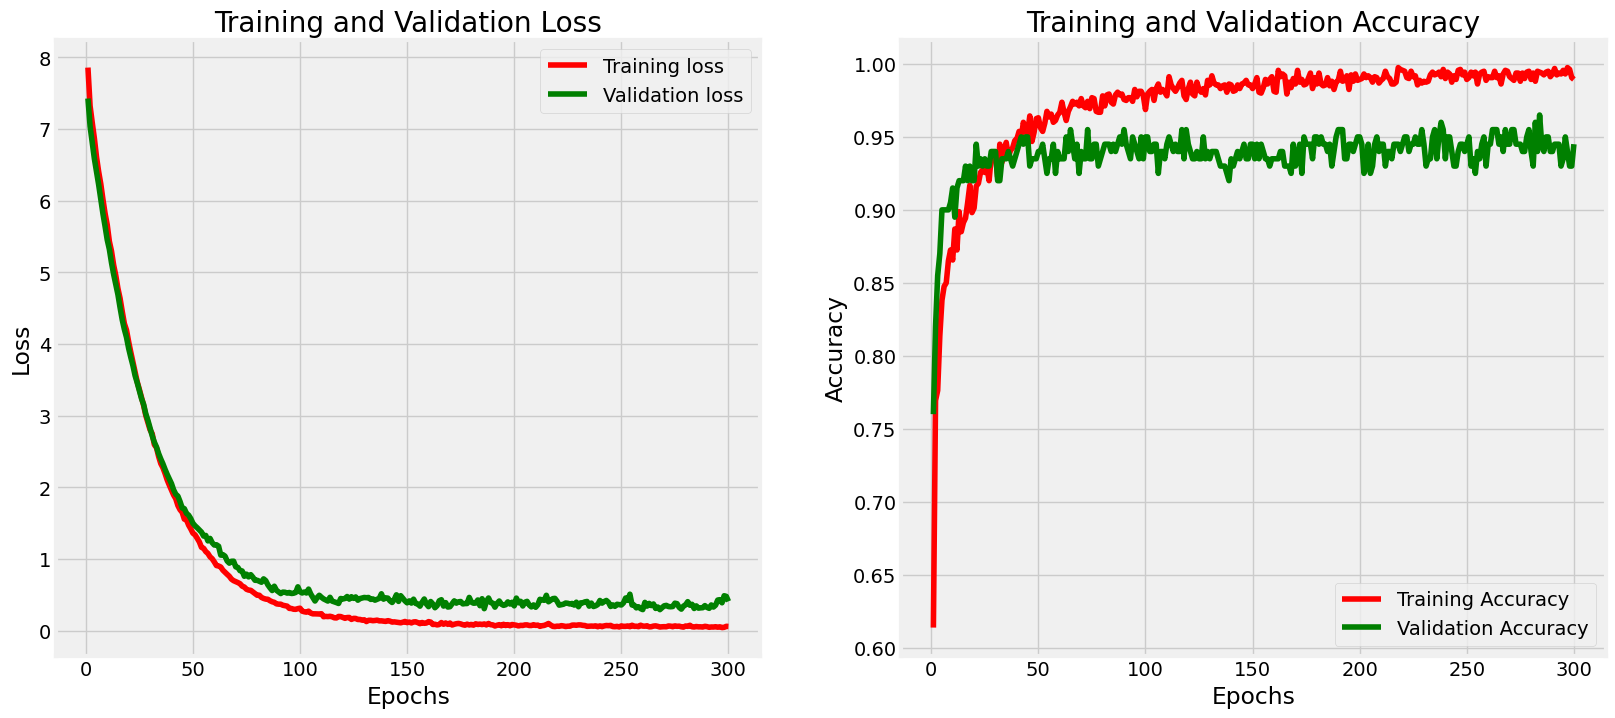

In [19]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


model_performance(history, 200)

20/20 [==============================] - 5s 229ms/step


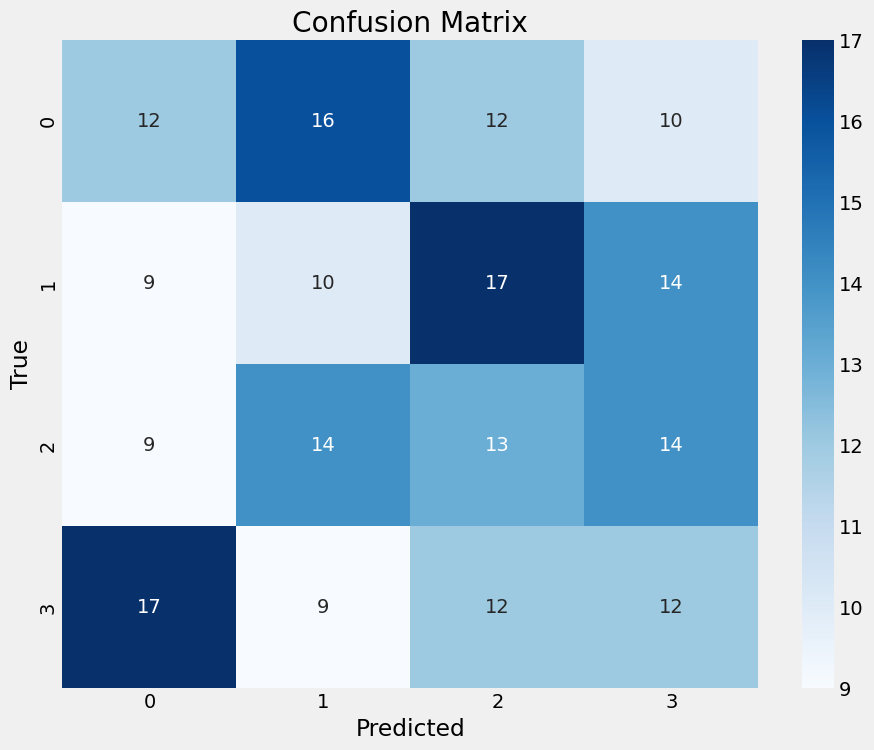

                precision    recall  f1-score   support

        Blight       0.26      0.24      0.25        50
   Common_Rust       0.20      0.20      0.20        50
Gray_Leaf_Spot       0.24      0.26      0.25        50
       Healthy       0.24      0.24      0.24        50

      accuracy                           0.23       200
     macro avg       0.24      0.23      0.23       200
  weighted avg       0.24      0.23      0.23       200



In [20]:
# Confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

In [21]:
# Save the full model in H5 format
model.save('model_corn.h5')
print('Saved full model as model_corn.h5')

# Convert and save the model to TFLite format
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('model_corn.tflite', 'wb') as tflite_file:
        tflite_file.write(tflite_model)
    print('Saved model as model_rice.tflite')
except Exception as e:
    print(f'Failed to convert to TFLite: {e}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved full model as model_corn.h5


Saved model as model_rice.tflite


In [22]:
# Download the model files
from google.colab import files

# Download Keras model
files.download('model_corn.h5')

# Download TFLite model
files.download('model_corn.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>